In [ ]:
Pkg.update()
Pkg.add("Jacobi")
Pkg.add("FastGaussQuadrature")
Pkg.add("PyPlot")

In [2]:
using FastGaussQuadrature
using Jacobi

nodePoints=100

function b_n(n::Int64)
    numerator = -n*(n+1)
    denominator = (n+2)*(n+3)
    return numerator/denominator
end

function M_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1, j+1] = 2/(2*i+1) + (b_n(i)*b_n(i))*(2/(2*i+5))
            elseif i==j+2
                fullMatrix[i+1, j+1] = b_n(j)*(2/(2*j+5))
            elseif i==j-2
                fullMatrix[i+1, j+1] = b_n(i)*(2/(2*j+1))
            end
        end
    end
    return fullMatrix/2
end

function B_ij(size::Int64)
    fullMatrix = zeros(size,size)
    for i=0:size-1
        for j=0:size-1
            if i==j
                fullMatrix[i+1,j+1]=2/(2*i+1)
            elseif i==j-2
                fullMatrix[i+1,j+1]=b_n(i)*2/(2*i+5)
            end
        end
    end
    return fullMatrix/2
end

function L_ij(size::Int64, S::Function)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dp_i = 2.*(djacobi(values[k+1],i,0,0)+b_n(i)*djacobi(values[k+1],i+2,0,0))
                dp_j = 2.*(djacobi(values[k+1],j,0,0)+b_n(j)*djacobi(values[k+1],j+2,0,0))
                newPiece = weights[k+1]*S((values[k+1]+1.)/2.)*dp_i*dp_j
                sumTotal = sumTotal + newPiece
            end
            fullArray[i+1,j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function S_constant(value::Float64)
    return 1.
end

function galerkin_p_psi_print(size::Int64, coefficients, value)
    sumTotal = 0
    for i=size-1:-1:0
        p = jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0)
        sumTotal = sumTotal + coefficients[i+1]*p
    end
    return sumTotal
end
;


Use "local i; local k; local iter=0" instead.

Use "abstract type QUADRATURE_TYPE end" instead.


# Linear Stability

In [65]:
function dq_galerkin_coefficients(size::Int64, dq_bar::Function)
    fullArray = zeros(size)
    values, weights = gausslegendre(nodePoints)
    for i =0:size-1
        sumTotal = 0
        for k=0:nodePoints-1
            p_n = jacobi(values[k+1], i,0,0)
            sumTotal = sumTotal + weights[k+1]*p_n*dq_bar((values[k+1]+1.)/2.)
        end
        fullArray[i+1] = .5*sumTotal
    end
    return fullArray
end

function dq_galerkin(size::Int64, coefficients, value::Float64)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*jacobi(2.*value-1.,i,0,0)
    end
    return sumTotal
end

function p_psi_function(size::Int64, value::Float64)
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)+b_n(i)*jacobi(2.*value-1.,i+2,0,0)
    end
    return fullArray
end

function p_q_function(size::Int64, value::Float64) # We shouldn't need this function
    fullArray = zeros(size)
    for i=0:size-1
        fullArray[i+1] = jacobi(2.*value-1.,i,0,0)
    end
    return fullArray
end

function dy_vartheta_bar(S::Function, du_bar::Function, value::Float64)
    return -S(value)*du_bar(value)
end

function dy_psi(u_bar::Function, value::Float64)
    return -u_bar(value)
end

function dy_psi_galerkin(size::Int64, u_bar_coefficients, value::Float64)
    return -u_galerkin(size, u_bar_coefficients, value)
end

function u_galerkin_coefficients(size::Int64, dq_coefficients, dvt_plus, dvt_minus, first_u_coefficient, du_bar::Function, S::Function, LMatrix, BMatrix)
    r_piece1 = BMatrix*dq_coefficients
    r_piece2 = dvt_plus*p_psi_function(size,1.0)
    r_piece3 = dvt_minus*p_psi_function(size,0.0)
    rhs = r_piece1-r_piece2+r_piece3
    lhs = LMatrix[2:size,2:size]
    rhs = rhs[2:size]
    coefficients = lhs \ rhs
    return prepend!(coefficients,[first_u_coefficient])
end

function u_galerkin(size::Int64, coefficients, value)
    sumTotal = 0
    for i=0:size-1
        sumTotal = sumTotal + coefficients[i+1]*(jacobi(2.*value -1., i, 0,0)+b_n(i)*jacobi(2.*value -1.,i+2,0,0))
    end
    return sumTotal
end

u_galerkin (generic function with 2 methods)

In [17]:
function U_ij(size::Int64, u_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                p_psi = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_q = jacobi(values[k+1],j,0,0)
                u_galerk = u_galerkin(size, u_galerkin_coefficients, (values[k+1]+1.)/2.)
                sumTotal = sumTotal + weights[k+1]*p_psi*p_q*u_galerk
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

function Q_ij(size::Int64, dq_galerkin_coefficients)
    fullArray = zeros(size,size)
    values, weights = gausslegendre(nodePoints)
    for i=0:size-1
        for j=0:size-1
            sumTotal = 0
            for k=0:nodePoints-1
                dq_galerk = dq_galerkin(size, dq_galerkin_coefficients, (values[k+1]+1.)/2.)
                p_psi_i = jacobi(values[k+1],i,0,0)+b_n(i)*jacobi(values[k+1],i+2,0,0)
                p_psi_j = jacobi(values[k+1],j,0,0)+b_n(j)*jacobi(values[k+1],j+2,0,0)
                sumTotal = sumTotal + weights[k+1]*dq_galerk*p_psi_i*p_psi_j
            end
            fullArray[i+1, j+1] = .5*sumTotal
        end
    end
    return fullArray
end

Q_ij (generic function with 1 method)

In [107]:
function psi(size, kx, ky, M_matrix, L_matrix, value)
    first_piece = (kx^2+ky^2)*M_matrix+L_matrix
    second_piece = p_psi_function(size, value)
    return first_piece \ second_piece
end

function q(size, value)
    return zeros(size)+value
end

function computeMatricesForStabilityAnalysis(sizeOfMatrix, S_function, dq_function, du_function,dvt_plus, dvt_minus, first_coefficient)
    B = B_ij(sizeOfMatrix)
    L = L_ij(sizeOfMatrix, S_function)
    M = M_ij(sizeOfMatrix)
    dq_coefficients = dq_galerkin_coefficients(sizeOfMatrix, dq_function)
    u_coefficients = u_galerkin_coefficients(sizeOfMatrix, dq_coefficients, dvt_plus, dvt_minus, first_coefficient, du_function, S_function, L, B)

    U = U_ij(sizeOfMatrix, u_coefficients)
    Q = Q_ij(sizeOfMatrix, dq_coefficients)
    println("Matrices Computed")
    return (B,L,M,U,Q, u_coefficients, dq_coefficients)
end

function getSimplifiedStabilityEigenObjectsOfKx(sizeOfMatrix, beta_value, ky, kxValues, S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    (B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(sizeOfMatrix,S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    #Should have stable eigenvalues
    (values, vectors) = eig(U, B)
    if(minimum(imag(values))>0)
        println("Stable piece is unstable...")
    end
    
    eigenObjects = []
    for i=1:length(kxValues)
        kx = kxValues[i]
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        ur = -dvt_plus*vecdot(p_psi_function(sizeOfMatrix, 1.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        ll = dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,1.))
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_function(sizeOfMatrix, 0.),psi(sizeOfMatrix,kx,ky,M,L,0.))
        lhs = [[ul ur]; [ll lr]]
        eigenResult = eigfact(lhs)
        append!(eigenObjects, [eigenResult])
    end
    println("Done computing eigenvalues and eigenvectors for all kx's")
    return eigenObjects
end

function getCompleteStabilityEigenObjectsOfKx(sizeOfMatrix, beta_value, ky, kxValues, S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    (B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(sizeOfMatrix,S_function, dq_function, du_function, dvt_plus, dvt_minus, first_coefficient)
    eigenObjects = []

    for i=1:length(kxValues)
        kx = kxValues[i]
        psi_plus = psi(sizeOfMatrix,kx,ky,M,L,1.)
        psi_minus = psi(sizeOfMatrix,kx,ky,M,L,0.)
        p_psi_plus = p_psi_function(sizeOfMatrix, 1.)
        p_psi_minus = p_psi_function(sizeOfMatrix, 0.)
        q_vector = q(sizeOfMatrix, dq_function(0.))
        centerRowMatrix = ((kx^2+ky^2)*M+L)\B
        
        ul = u_galerkin(sizeOfMatrix, u_coefficients, 1.)+dvt_plus*vecdot(p_psi_plus,psi_plus)
        uc = -(dvt_plus)*vecdot(p_psi_plus,centerRowMatrix*q_vector)
        ur = -dvt_plus*vecdot(p_psi_plus, psi_minus)
        cl = vecdot((Q+beta_value*M)*psi_plus, q_vector)
        cc = vecdot((U-(Q+beta_value*M)*centerRowMatrix)*q_vector,q_vector)
        cr = -vecdot((Q+beta_value*M)*psi_minus, q_vector)
        ll = dvt_minus*vecdot(p_psi_minus,psi_plus)
        lc = -(dvt_minus)*(vecdot(p_psi_minus,centerRowMatrix*q_vector))
        lr = u_galerkin(sizeOfMatrix, u_coefficients, 0.)-dvt_minus*vecdot(p_psi_minus,psi_minus)
        lhs = [[ul uc ur];[cl cc cr];[ll lc lr]]
        
        rhs = [[1 0 0];[0 vecdot(B*q_vector,q_vector) 0]; [0 0 1]]
        eigenResult = eigfact(lhs, rhs)
        append!(eigenObjects, [eigenResult])
    end
    println("Done computing eigenvalues and eigenvectors for all kx's")
    return eigenObjects
end
    
function getStabilityValues(eigenObjectsArray, kxValues)
    steps = length(kxValues)
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    minWaveSpeeds = zeros(steps)
    eigenvectors = []
    
    for i=1:steps
        kx = kxValues[i]
        max_im = maximum(imag(eigenObjectsArray[i][:values]))
        append!(eigenvectors, [eigenObjectsArray[i][:vectors]])
        waveSpeeds[i] = maximum(real(eigenObjectsArray[i][:values]))
        minWaveSpeeds[i] = minimum(real(eigenObjectsArray[i][:values]))
        growthRates[i] = max_im*kx
    end
    
    return growthRates, eigenvectors, waveSpeeds, minWaveSpeeds
end

getStabilityValues (generic function with 1 method)

# Eady Problem

In [53]:
function z_linear(value::Float64)
    return value
end

function dz(value::Float64)
    return 1
end 

function dq(value::Float64)
    return 0
end
first_coefficient = 0.5
matrixSize = 15
B = B_ij(matrixSize)
L = L_ij(matrixSize, S_constant)
M = M_ij(matrixSize)

dqc = dq_galerkin_coefficients(matrixSize, dq)
ugc = u_galerkin_coefficients(matrixSize, dqc,dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient, dz, S_constant, L, B)

#Test method
u_galerkin(matrixSize, ugc, .1)
#U_ij(matixSize, ugc)

#dq_galerkin(matrixSize, dqc, .3)
#Q_ij(matrixSize, dqc)

0.09894357881798532

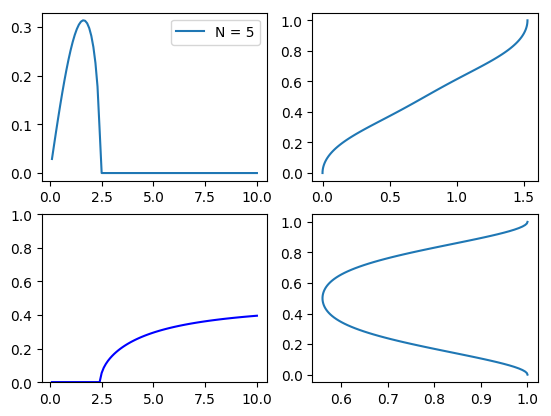

Matrices Computed
Done computing eigenvalues and eigenvectors for all kx's
Max growth rate at kx=1.6

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000027343240>

In [108]:
using PyPlot
ioff()

nodePoints = 100 # redefining for ease of alteration
matrixSize = 5

B = B_ij(matrixSize)
L = L_ij(matrixSize, S_constant)
M = M_ij(matrixSize)

kxStart = 0.1
kxFinish = 10.
steps = 100
beta = 0
ky = 0
kxs = linspace(kxStart, kxFinish, steps)
eigenValuesAndVectors = getSimplifiedStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_constant, dq, dz, dy_vartheta_bar(S_constant, dz, 1.), dy_vartheta_bar(S_constant, dz, 0.), first_coefficient)
growthRates, vectors, w_speeds, w_minSpeeds = getStabilityValues(eigenValuesAndVectors, kxs)

maxIndex = indmax(growthRates)
maxKx = kxs[maxIndex]
print("Max growth rate at kx=$maxKx")
highVector = vectors[maxIndex]
psi_coeffs = highVector[1]*psi(matrixSize, 1.6, ky, M, L, 1.)-highVector[2]*psi(matrixSize,1.6,ky, M,L,0.)

heights = linspace(0,1,100)
psi_angles = zeros(length(heights))
psi_amps = zeros(length(heights))
for i=1:length(heights)
    psi_val = galerkin_p_psi_print(matrixSize, psi_coeffs, heights[i])
    psi_angles[i] = angle(psi_val)
    psi_amps[i] = abs(psi_val)
end

#print(kxs[25])
fig, axes = subplots(2,2)
ax = axes[1,1]
ax[:plot](kxs, growthRates, label="N = $matrixSize")
ax[:legend](loc="upper right")
ax = axes[2,1]
ax[:plot](kxs, w_speeds, "b-")
ax[:plot](kxs, w_minSpeeds, "b-")
ax[:set_ylim]([0,1])
ax = axes[1,2]
ax[:plot](psi_angles - psi_angles[1], heights)

ax = axes[2,2]
ax[:plot](psi_amps/maximum(psi_amps), heights)

# Ocean-Charney Stability

In [109]:
using PyPlot

function u_OC(value)
    if(value isa Number)
        return 1/54*(3*exp(6*value)*(6*value -1)-2*exp(6)-1)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 1/54*(3*exp(6*value[i])*(6*value[i] -1)-2*exp(6)-1)
        end
        return vector
    end
end

function dq_OC(value)  
    if(value isa Number)
        return -2
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = -2
        end
        return vector
    end
end

function S_OC(value)
    if(value isa Number)
        return exp(-6*value)
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = exp(-6*value[i])
        end
        return vector
    end
end
   
function du_OC(value)
    if(value isa Number)
        return 1/54(108*value*exp(6*value))
    else
        vector = zeros(length(value))
        for i=1:length(value)
            vector[i] = 1/54(108*value[i]*exp(6*value[i]))
        end
        return vector
    end
end

first_coefficient = 0
matrixSize = 12
kxStart = 0.1
kxFinish = 10.
steps = 100
beta = 0
ky = 0
kxs = linspace(kxStart, kxFinish, steps)

#= Test set 
(B,L,M,U,Q,u_coefficients,dq_coefficients) = computeMatricesForStabilityAnalysis(matrixSize,S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
testPoint = 0.9
realValue = u_OC(testPoint)
galerkinValue = u_galerkin(matrixSize, u_coefficients, testPoint)
x = 0.1:0.01:0.9
plot(x, u_OC(x), x, u_galerkin(matrixSize, u_coefficients, x))
=#

eigenValuesAndVectors = getCompleteStabilityEigenObjectsOfKx(matrixSize, beta, ky, kxs, S_OC, dq_OC, du_OC, -2, 0, first_coefficient)
println(eigenValuesAndVectors[1])

Matrices Computed
Done computing eigenvalues and eigenvectors for all kx's
Base.LinAlg.GeneralizedEigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}([-102.157, 67.8273, -15.0346], [-1.0 1.0 1.0; 0.214971 -0.600401 -0.127789; -0.0 0.0 0.67608])


# First Baroclinic Mode Comparison

In [ ]:
using PyPlot

function isNonZero(value)
    return (value != 0)
end

function firstBaroclinic(value)
    return cos.(pi*value)
end

function computeFirstBaroclinicError(matrixSize, trueFirstFuction, stepsZeroToOne, S_function)
    #Compute Matricies
    M = M_ij(matrixSize)
    #spy(Hermitian(M))
    L = L_ij(matrixSize, S_function)
    G = chol(M)'

    #Compute eigenvalues and eigenvectors
    LGL = (G\L)/(G')
    eigenObject = eigfact(LGL)
    e_vectors = eigenObject[:vectors]
    e_values = eigenObject[:values]
    minimumNonZero = minimum(filter!(isNonZero,e_values))
    index = findfirst(e_values, minimumNonZero)
    neededEVector = e_vectors[:,index]
    neededEVector = (LGL - e_values[index]*eye(matrixSize))\neededEVector
    neededEVector = G'\neededEVector
    #println(neededEVector)
#    normalizationFactor = 1./galerkin_p_psi_print(matrixSize, neededEVector, 0.)
    
    #Calculate Error
    z, weights = gausslegendre(stepsZeroToOne)
    real = trueFirstFuction(z)
    estimate = galerkin_p_psi_print(matrixSize, neededEVector, z)
    normalizationFactor = dot(weights,real.*estimate)/dot(weights,estimate.*estimate)
    estimate = normalizationFactor*estimate
    #println("True Values: $real")
    #println("Appx Values: $estimate")
    #println()
#    sumError = 0.
#    for i=1:length(z)
#        sumError += abs2(real[i]-estimate[i])
#    end
#    totalError = sqrt(sumError/stepsZeroToOne)
    totalError = sqrt(dot(weights,abs2.(real-estimate)))
    return totalError
end

#computeFirstBaroclinicError(15, firstBaroclinic, 10)

errors = zeros(20)
nValues = 3:22;
for i =nValues
    #println("N = $i")
    errors[i-2] = computeFirstBaroclinicError(i, firstBaroclinic, 201, S_constant)
    #println()
end
#plot(nValues,errors)
loglog(nValues[2:2:end], errors[2:2:end])

# Finite Difference Analysis

In [3]:
function z_elements(size)
    stepSize = 1/size
    elements = zeros(size)
    elements[1] = stepSize/2
    for i = 2:size
        elements[i] = elements[i-1]+stepSize;
    end
    return elements
end

function U_fd(size, u_function)
    z_k = z_elements(size)
    fullMatrix = Diagonal(u_function(z_k))
    return fullMatrix
end

function L_fd(size, S)
    deltaZ = 1/size
    fullMatrix = zeros(size, size)
    fullMatrix[1,1] = S(deltaZ)
    fullMatrix[1,2] = -S(deltaZ)
    fullMatrix[size,size] = S((size-1)*deltaZ)
    fullMatrix[size,size-1] = -S((size-1)*deltaZ)
    for i=2:size-1
        fullMatrix[i, i-1] = -S((i-1)*deltaZ)
        fullMatrix[i,i] = S((i-1)*deltaZ)+S(i*deltaZ)
        fullMatrix[i, i+1] = -S(i*deltaZ)
    end
    normalize = 1./(deltaZ^2)
    return fullMatrix*normalize
end

function Q_fd(size, u_function, L_matrix)
    zk = z_elements(size)
    u_matrix = u_function(zk)
    diagonals = L_matrix*u_matrix
    fullMatrix = Diagonal(diagonals)
    return fullMatrix
end

#z_elements(8)
#L = L_fd(5, z_linear)
#Q_fd(5,u_linear,L)

Q_fd (generic function with 1 method)

In [9]:
function u_linear(value)
    return value
end

function growthRateEigenValues_fd(sizeOfMatrix, beta_value, ky, kxValues, steps, S_function)
    U = U_fd(sizeOfMatrix, u_linear)
    L = L_fd(sizeOfMatrix, S_function)
    Q = Q_fd(sizeOfMatrix, u_linear, L)
    println("Matrices Computed")
    
    growthRates = zeros(steps)
    waveSpeeds = zeros(steps)
    minWaveSpeeds = zeros(steps)
    eigenvectors = []
    for i=1:steps
        #println()
        kx = kxValues[i]
        lhs = U*(Diagonal(zeros(sizeOfMatrix)+(kx^2+ky^2))+L) - (Q+Diagonal(zeros(sizeOfMatrix)+beta_value))
        rhs = Diagonal(zeros(sizeOfMatrix)+(kx^2+ky^2))+L
        #println(lhs)
        eigenObject = eigfact(lhs, rhs)
        max_im = maximum(imag(eigenObject[:values]))
        #println(eigenObject[:vectors])
        append!(eigenvectors, [eigenObject[:vectors]])
        waveSpeeds[i] = maximum(real(eigenObject[:values]))
        minWaveSpeeds[i] = minimum(real(eigenObject[:values]))
        growthRates[i] = max_im*kx
    end
    return growthRates, eigenvectors, waveSpeeds, minWaveSpeeds
end

growthRateEigenValues_fd (generic function with 1 method)

# Finite Difference - Eady Problem

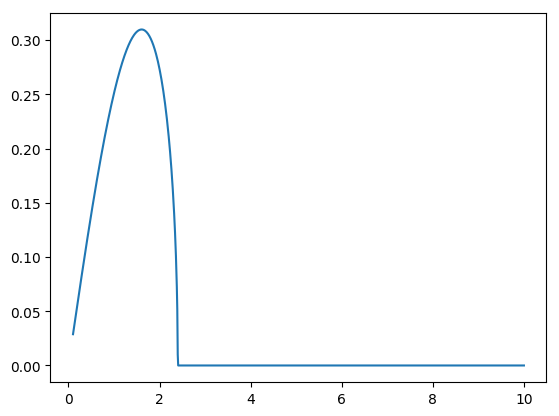

Matrices Computed


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000049C57B8>

In [10]:
using PyPlot
matrixSize = 100

kxStart = 0.1
kxFinish = 10.
steps = 1000
beta = 0
ky = 0

kxs = linspace(kxStart, kxFinish, steps)
growthRates, vectors, w_speeds, w_minSpeeds = growthRateEigenValues_fd(matrixSize, beta, ky, kxs, steps, S_constant)
plot(kxs, growthRates)